# Sarcasm classification with different word embeddings

Importing necessary libraries/functions and reading the data.

In [1]:
# Imports
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
import torch
import transformers as ppb
from transformers import DistilBertTokenizer, DistilBertModel
import matplotlib.pyplot as plt
import seaborn as sns
tqdm_notebook.pandas()

/Users/cosmo/opt/anaconda3/envs/tm/lib/python3.7/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
def plot_class_balance(data, label_col, label_dict, relative = True):
    """
    Helper function to plot class bar plots
    
    Input:
        data: pandas Dataframe. Data to plot.
        label_col: pandas Series. Label column.
        label_dict: dict. Dictionary containing  label names as values and label numbers as keys.
        relative: boolean. Plot relative frequencies instead of absolute count. Defaults to True.
    
    Return:
        None.
    """
    plt.figure()

    labels = label_dict.values()
    counts = label_col.value_counts()

    if relative:
        plt.title('Relative frequencies of classes')
        plt.ylabel('Relative frequency')
        counts = counts/sum(counts)
        
    else:
        plt.title('Counts of classes')
        plt.ylabel('Count') 
        counts = counts

    plt.bar(labels, counts, color = sns.color_palette(palette = "pastel", n_colors= len(labels)))
    plt.show()

In [4]:
# Reading data
sarcasm = pd.read_json('../data/Sarcasm_Headlines_Dataset_v2.json', lines = True)
sarcasm.drop('article_link', axis = 1, inplace=True)
sarcasm.rename(columns = {'is_sarcastic': 'label', 'headline':'text'}, inplace=True)

In [43]:
sarcasm.label.value_counts()/sum(sarcasm.label.value_counts())

0    0.523603
1    0.476397
Name: label, dtype: float64

In [4]:
# Having a quick look
sarcasm.head()

,label,text
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


### Assesing class balance

 It is a little bit unbalanced torwards not-sarcastic headlines, but it is balanced enough.

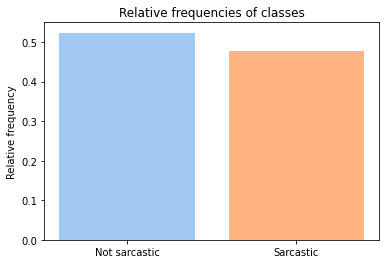

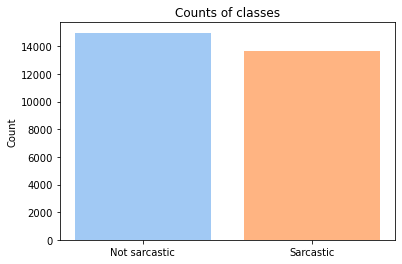

In [5]:
plot_class_balance(sarcasm, sarcasm['label'], label_dict={0: 'Not sarcastic', 1:'Sarcastic'}) # not exaclty perfect

plot_class_balance(sarcasm, sarcasm['label'], label_dict={0: 'Not sarcastic', 1:'Sarcastic'}, relative = False) 

In [6]:
# Some descriptive statistics
print(sarcasm["text"].str.split(' ').str.len().describe())

count    28619.000000
mean        10.051854
std          3.390939
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max        151.000000
Name: text, dtype: float64


### Preprocessing text

Preprocessing function: lower casing and lemmatizing only.

In [7]:
# Preprocessing
nlp = spacy.load("en_core_web_lg", disable = ["tagger", "parser", "ner"])


""" def preprocess(text):
    doc = nlp(text)
    # lowercase - Tokenization - Stop word removal - Lemmatization
    return ' '.join([token.lemma_.lower() for token in doc]) """

" def preprocess(text):\n    doc = nlp(text)\n    # lowercase - Tokenization - Stop word removal - Lemmatization\n    return ' '.join([token.lemma_.lower() for token in doc]) "

In [8]:
""" sarcasm['preprocessed'] = sarcasm['text'].apply(preprocess) """

" sarcasm['preprocessed'] = sarcasm['text'].apply(preprocess) "

In [9]:
""" # Having (another) quick look
sarcasm.head() """

' # Having (another) quick look\nsarcasm.head() '

## Dummy classifier (random chance)

              precision    recall  f1-score   support

           0       0.52      0.52      0.52      4916
           1       0.48      0.48      0.48      4529

    accuracy                           0.50      9445
   macro avg       0.50      0.50      0.50      9445
weighted avg       0.50      0.50      0.50      9445

/Users/cosmo/opt/anaconda3/envs/tm/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


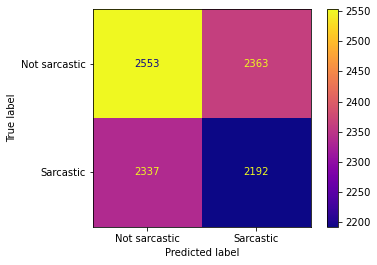

In [10]:
X = sarcasm['text']
y = sarcasm['label']
Xtrain,Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.33, random_state = 42)

#### DUMMY CLASSIFIER ####
# Defaults to stratified method (class distribution)
dumb = DummyClassifier() 

# Fitting to TRAINING data
dumb.fit(Xtrain, ytrain)

# Predicting TEST data
dumb_pred = dumb.predict(Xtest)

# Evaluating 
print(classification_report(y_true = ytest,
                            y_pred = dumb_pred))
labels = ['Not sarcastic', 'Sarcastic']
plot_confusion_matrix(dumb, Xtest ,ytest, display_labels = labels, cmap = 'plasma')



## Tfidf vectorization

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      4916
           1       0.78      0.78      0.78      4529

    accuracy                           0.79      9445
   macro avg       0.79      0.79      0.79      9445
weighted avg       0.79      0.79      0.79      9445



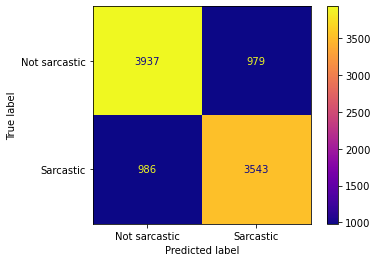

In [11]:
#### TFIDF ####

# Instantiating pipeline
tfidf_pipe = Pipeline( steps = [
    ('tfidf', TfidfVectorizer(max_features = 1000, ngram_range = (1,2))),
    ('svc', LinearSVC())
    ]
)

# Training
tfidf_pipe.fit(Xtrain, ytrain)

# Predicting
tfidf_pred = tfidf_pipe.predict(Xtest)

# Evaluating
print(classification_report(y_true = ytest, y_pred = tfidf_pred))

labels = ['Not sarcastic', 'Sarcastic']
plot_confusion_matrix(tfidf_pipe, Xtest ,ytest, display_labels = labels, cmap = 'plasma')

In [12]:
sarcasm['w2v-vec'] = sarcasm['text'].apply(lambda row: nlp(row).vector)

In [13]:
# Having (yet another) look
sarcasm.head()

,label,text,w2v-vec
0,1,thirtysomething scientists unveil doomsday clo...,"[-0.012716755, -0.03580188, -0.015194628, -0.0..."
1,0,dem rep. totally nails why congress is falling...,"[-0.09931787, 0.16092001, -0.104666196, 0.0016..."
2,0,eat your veggies: 9 deliciously different recipes,"[-0.18291537, 0.04772166, -0.004737884, -0.051..."
3,1,inclement weather prevents liar from getting t...,"[-0.059255533, 0.06309263, -0.16341561, -0.016..."
4,1,mother comes pretty close to using word 'strea...,"[-0.05888221, 0.14643422, -0.26493156, 0.10541..."


In [14]:
X = sarcasm['w2v-vec']
y = sarcasm['label']
Xtrain,Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.33, random_state = 42)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      4916
           1       0.81      0.80      0.80      4529

    accuracy                           0.81      9445
   macro avg       0.81      0.81      0.81      9445
weighted avg       0.81      0.81      0.81      9445



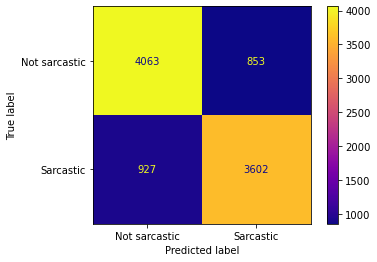

In [15]:
# Creating pipeline
w2v_pipe = Pipeline([("svc", LinearSVC(random_state = 42))])

w2v_model = w2v_pipe.fit(list(Xtrain), ytrain)

# Prediction
pred = w2v_model.predict(list(Xtest))

# Evaluation
print(classification_report(y_true = ytest,
                            y_pred = pred))

labels = ['Not sarcastic', 'Sarcastic'] 
plot_confusion_matrix(w2v_pipe, list(Xtest) ,ytest,  display_labels = labels, cmap = 'plasma')

# DistilBERT embeddings

First, loading the pre-trained embeddings.

In [5]:
# Load pretrained distilBERT model/tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased', output_hidden_states = True)

Now, prepare the text to be fed to distilBERT. Judging by the size of each headline, a dimension of 25 seems ideal for this data.

In [6]:
# Tokenization and padding
sarcasm['BERT-tokenized'] = sarcasm['text'].progress_apply((lambda row: tokenizer.encode(row, add_special_tokens=True, truncation = True, padding = 'max_length', max_length = 25)))

In [18]:
# Having (yet another) look at our data
sarcasm.head()

,label,text,w2v-vec,BERT-tokenized
0,1,thirtysomething scientists unveil doomsday clo...,"[-0.012716755, -0.03580188, -0.015194628, -0.0...","[101, 4228, 14045, 20744, 6529, 4895, 3726, 40..."
1,0,dem rep. totally nails why congress is falling...,"[-0.09931787, 0.16092001, -0.104666196, 0.0016...","[101, 17183, 16360, 1012, 6135, 10063, 2339, 3..."
2,0,eat your veggies: 9 deliciously different recipes,"[-0.18291537, 0.04772166, -0.004737884, -0.051...","[101, 4521, 2115, 2310, 13871, 3111, 1024, 102..."
3,1,inclement weather prevents liar from getting t...,"[-0.059255533, 0.06309263, -0.16341561, -0.016...","[101, 4297, 16930, 4765, 4633, 16263, 16374, 2..."
4,1,mother comes pretty close to using word 'strea...,"[-0.05888221, 0.14643422, -0.26493156, 0.10541...","[101, 2388, 3310, 3492, 2485, 2000, 2478, 2773..."


In [7]:
# Example

print(f'This is the headline:\n\n{sarcasm["text"][0]}\n\n')

print(f'This is the tokenized headline:\n\n{ tokenizer.convert_ids_to_tokens(sarcasm["BERT-tokenized"][0])}\n\n')

print(f'This is the token ID headline, padded:\n\n{sarcasm["BERT-tokenized"][0]}')

This is the headline:

thirtysomething scientists unveil doomsday clock of hair loss


This is the tokenized headline:

['[CLS]', 'thirty', '##some', '##thing', 'scientists', 'un', '##ve', '##il', 'doom', '##sd', '##ay', 'clock', 'of', 'hair', 'loss', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


This is the token ID headline, padded:

[101, 4228, 14045, 20744, 6529, 4895, 3726, 4014, 12677, 16150, 4710, 5119, 1997, 2606, 3279, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
# Running distilBERT (uncomment this cell. WARNING: it will take some time.)


# Preparing tokenized sentences to be fed to distilBERT
bert_input = np.array([np.array(sentence) for sentence in tqdm(sarcasm['BERT-tokenized'], desc = 'Converting to array', colour = 'blue')])
bert_input = torch.tensor(bert_input)
# Sanity check: should be [num_sentences x embedding size]
print(bert_input.shape)

with torch.no_grad():
    last_hidden_states = model(bert_input)

X_embedded = last_hidden_states[0][:,0,:]

# Saving embeddings to file to avoid reruns 
torch.save(X_embedded, 'distilbert_embeddings-sarcasm.pt')

Converting to array: 100%|██████████| 28619/28619 [00:00<00:00, 261203.36it/s]torch.Size([28619, 25])



In [21]:
# Loading embeddings from file
X_BERT_embedded = torch.load('distilbert_embeddings-sarcasm.pt')

In [22]:
X = X_BERT_embedded
y = sarcasm['label']
Xtrain,Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.33, random_state = 42)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4916
           1       0.84      0.86      0.85      4529

    accuracy                           0.86      9445
   macro avg       0.86      0.86      0.86      9445
weighted avg       0.86      0.86      0.86      9445



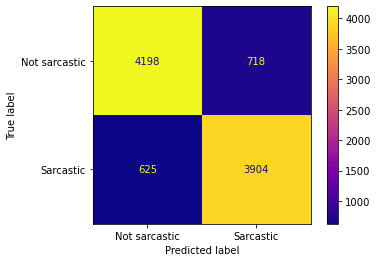

In [23]:
# Creating pipeline
BERT_pipe = Pipeline([("svc", LinearSVC(random_state = 42, max_iter = 5000))])

BERT_model = BERT_pipe.fit(Xtrain, ytrain)

# Prediction
BERT_pred = BERT_model.predict(Xtest)

# Evaluation
print(classification_report(y_true = ytest,
                            y_pred = BERT_pred))

labels = ['Not sarcastic', 'Sarcastic'] 
plot_confusion_matrix(BERT_pipe, Xtest ,ytest,  display_labels = labels, cmap = 'plasma')